In [24]:
%load_ext autoreload
%autoreload 2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import sys
sys.path.append('../../../src/benchmark/')
sys.path.append('../../../src/utils/')
from build_model import resnet50_, densenet161_, fpn_resnet50_classification, xcit_small
from utils import hdf5_dataset, list_to_dict, viz_dataloader
from prediction_analysis import confusion_matrix, plot_cm, prediction_vs_actual, most_confused, show_cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


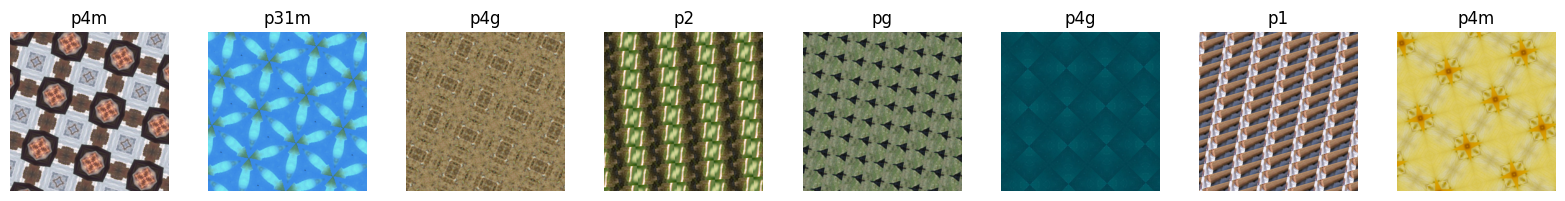

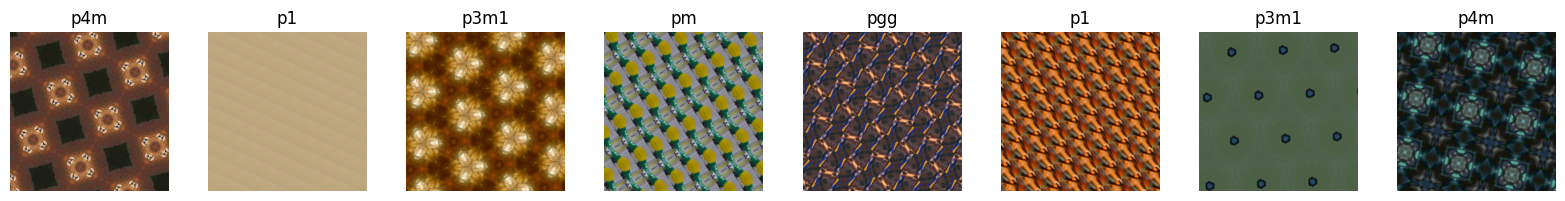

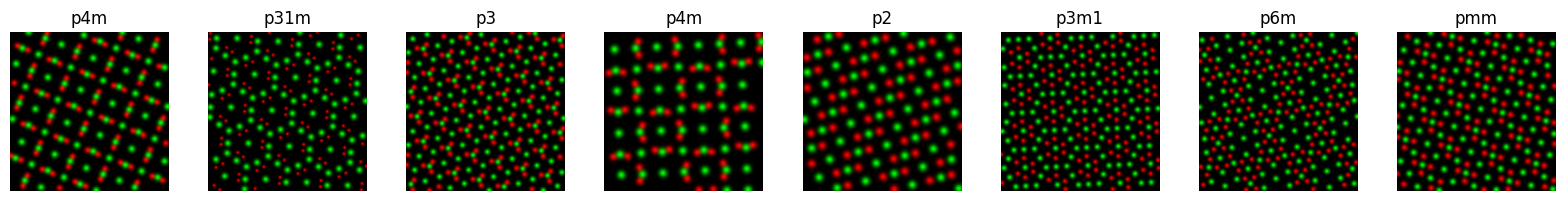

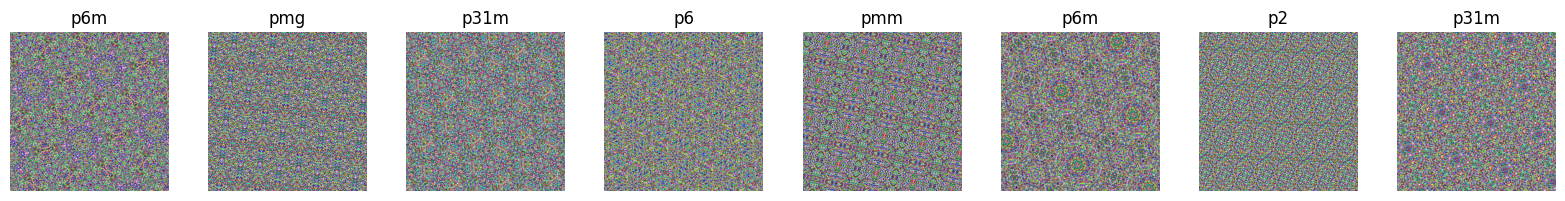

In [2]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

# imagenet
train_ds = hdf5_dataset('../../../datasets/imagenet_v4_rot_10m_train_unchunked.h5', folder='train', transform=transforms.ToTensor())
train_dl = DataLoader(train_ds, batch_size=1028, shuffle=False, num_workers=2)
viz_dataloader(train_dl, label_converter=label_converter)

valid_ds = hdf5_dataset('../../../datasets/imagenet_v4_rot_2m_valid_unchunked.h5', folder='valid', transform=transforms.ToTensor())
valid_dl = DataLoader(valid_ds, batch_size=1028, shuffle=False, num_workers=2)
viz_dataloader(valid_dl, label_converter=label_converter)

cv_atom_ds = hdf5_dataset('../../../datasets/atom_v4_rot_2m_unchunked.h5', folder='test', transform=transforms.ToTensor())
cv_atom_dl = DataLoader(cv_atom_ds, batch_size=1028, shuffle=False, num_workers=2)
viz_dataloader(cv_atom_dl, label_converter=label_converter)

cv_noise_ds = hdf5_dataset('../../../datasets/noise_v4_rot_2m-test.h5', folder='test', transform=transforms.ToTensor())
cv_noise_dl = DataLoader(cv_noise_ds, batch_size=1028, shuffle=False, num_workers=2)
viz_dataloader(cv_noise_dl, label_converter=label_converter)

In [4]:
NAME = '01102024-benchmark-XCiT-v4_10m'
device = torch.device('cuda:4')

model = xcit_small(3, 17)
model = torch.load('../../../saved_models/01102024-benchmark-XCiT-v4_10m/01102024-benchmark-XCiT-v4_10m-epoch-20.pt', map_location=device)
model = model.module
print(model(torch.randn(2, 3, 256, 256).to(device)).shape)

torch.Size([2, 17])


### generate confusion matrix

In [4]:
cm = confusion_matrix(model, train_dl, symmetry_classes, device, n_batches='all')
np.save(f'../../../saved_results/Benchmark/XCiT/{NAME}-train_imagenet_cm.npy', cm)

cm = confusion_matrix(model, valid_dl, symmetry_classes, device, n_batches='all')
np.save(f'../../../saved_results/Benchmark/XCiT/{NAME}-valid_imagenet_cm.npy', cm)

cm = confusion_matrix(model, cv_atom_dl, symmetry_classes, device, n_batches='all')
np.save(f'../../../saved_results/Benchmark/XCiT/{NAME}-cv_atom_cm.npy', cm)

cm = confusion_matrix(model, cv_noise_dl, symmetry_classes, device, n_batches='all')
np.save(f'../../../saved_results/Benchmark/XCiT/{NAME}-cv_noise_cm.npy', cm)

  0%|          | 0/9728 [00:00<?, ?it/s]

 92%|█████████▏| 8918/9728 [11:04:07<59:58,  4.44s/it]  

### visualize confusions 

printing set for seaborn


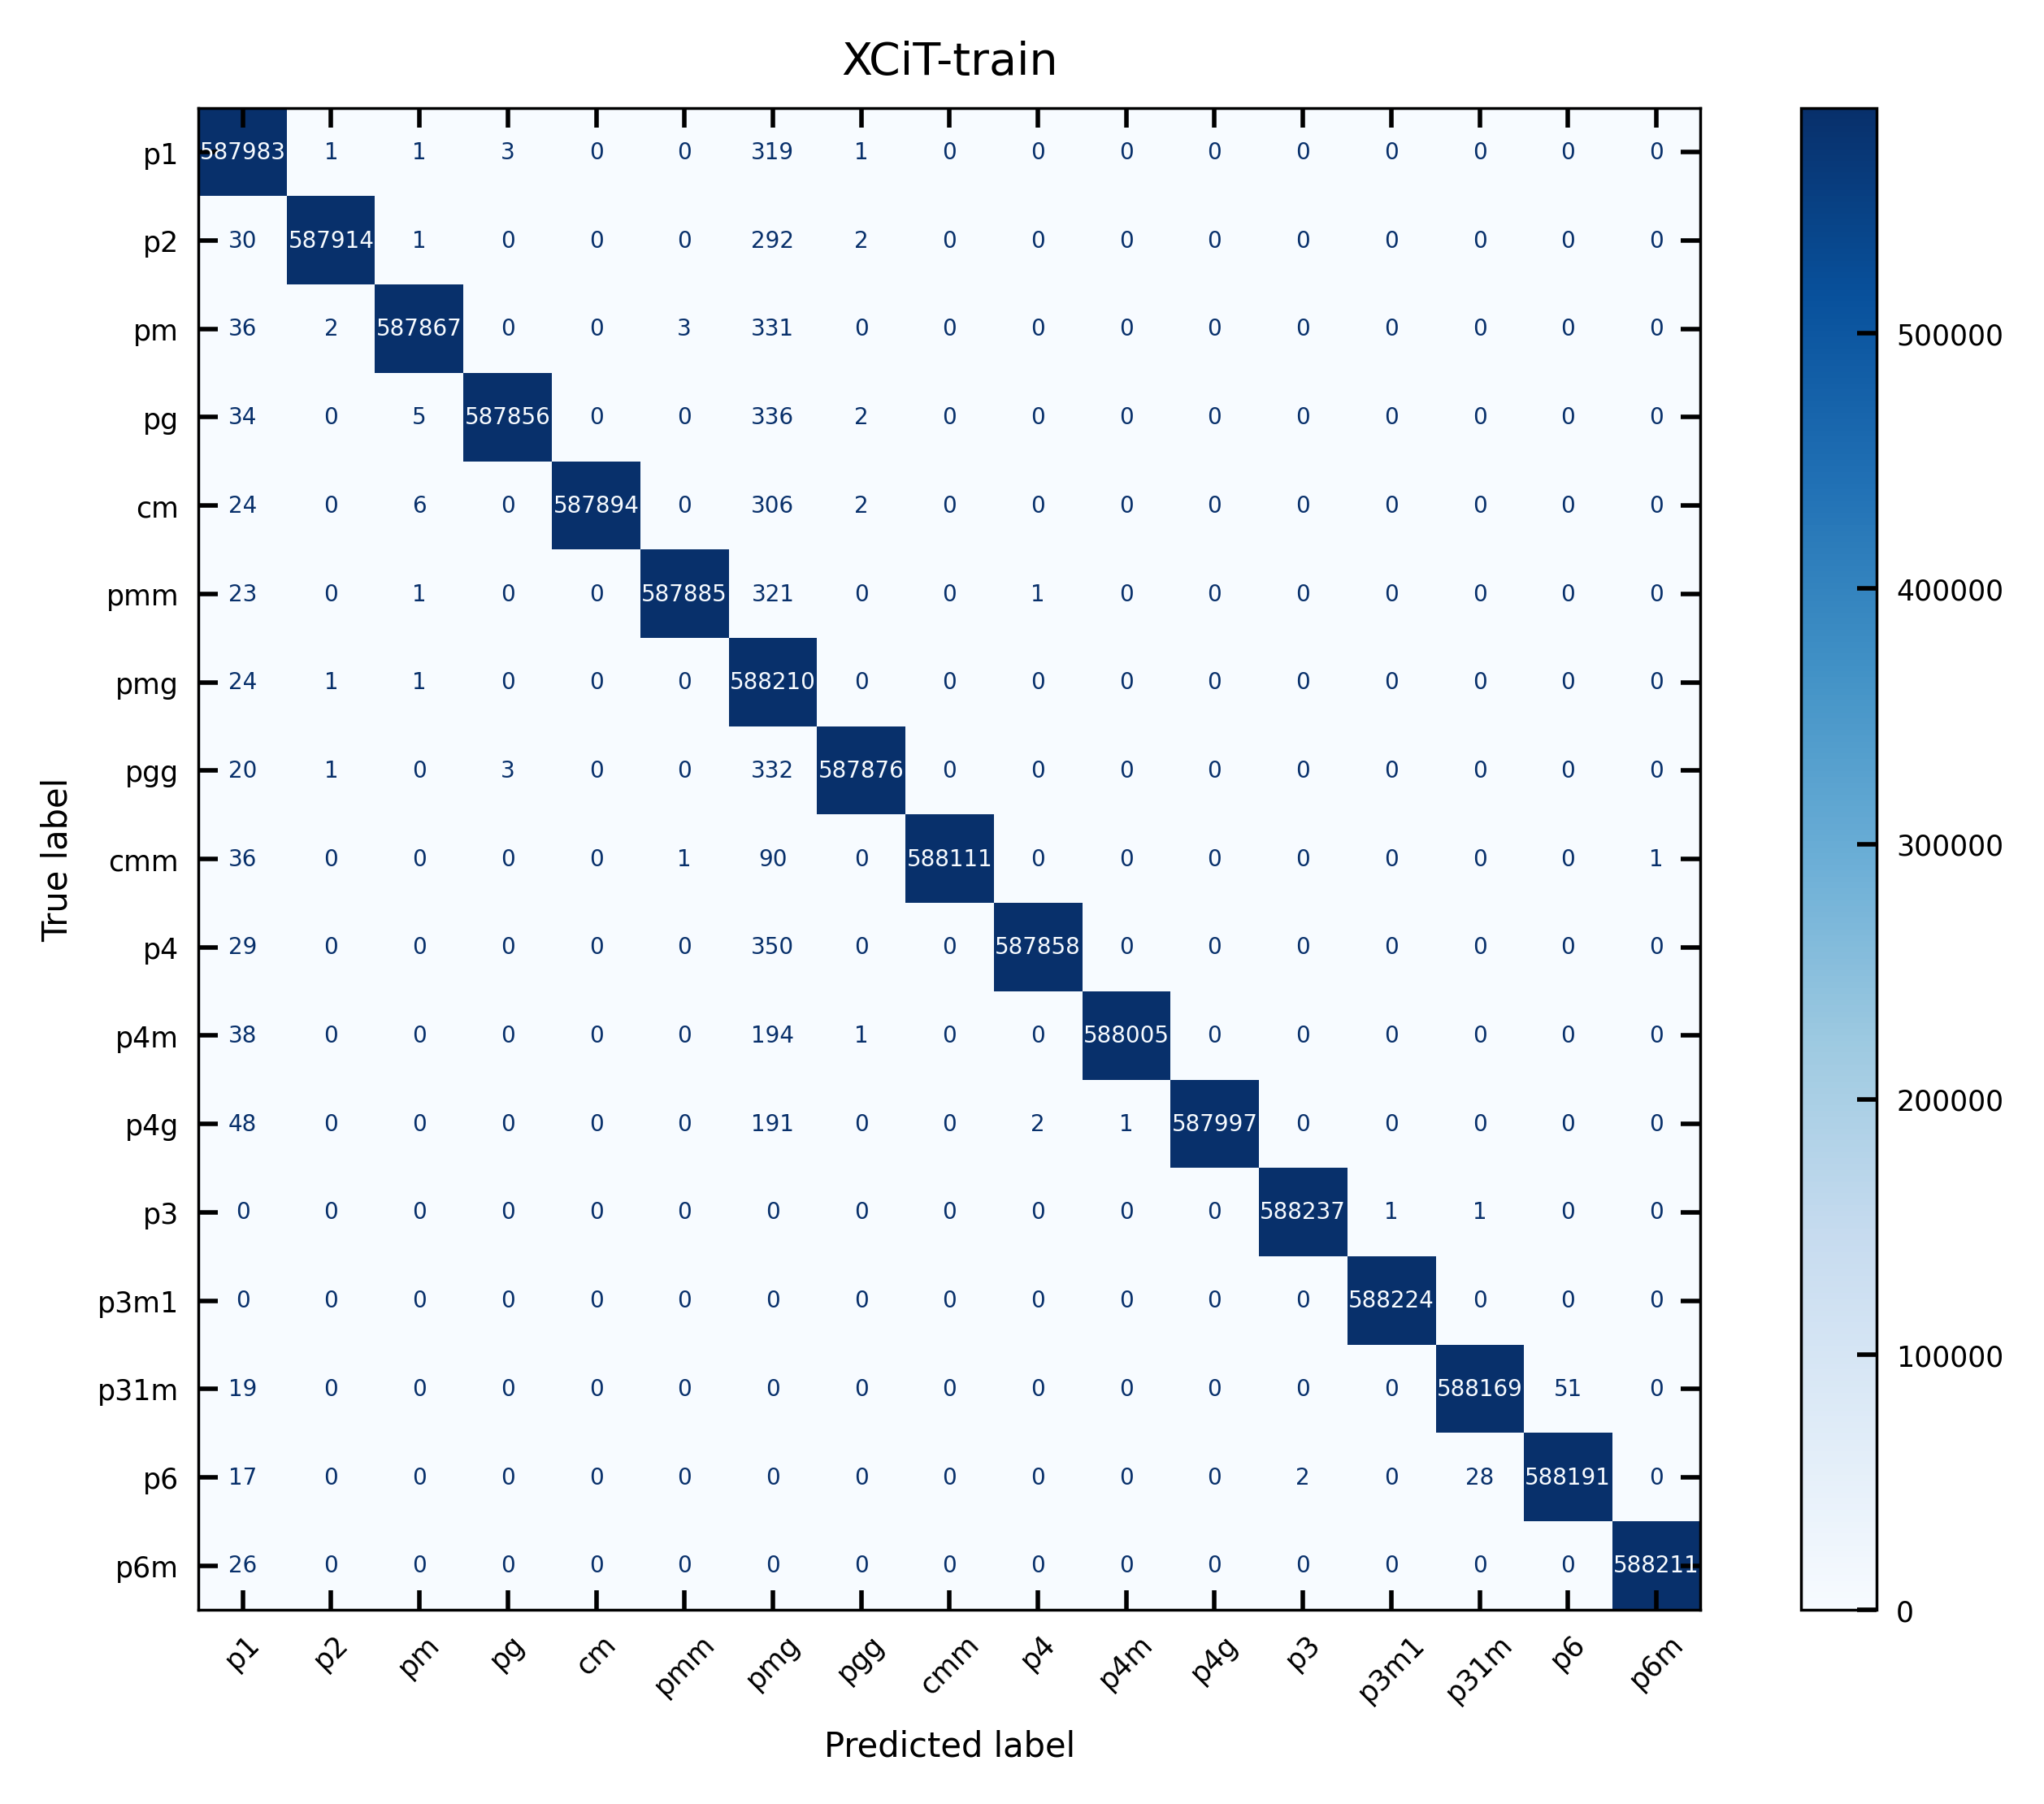

printing set for seaborn


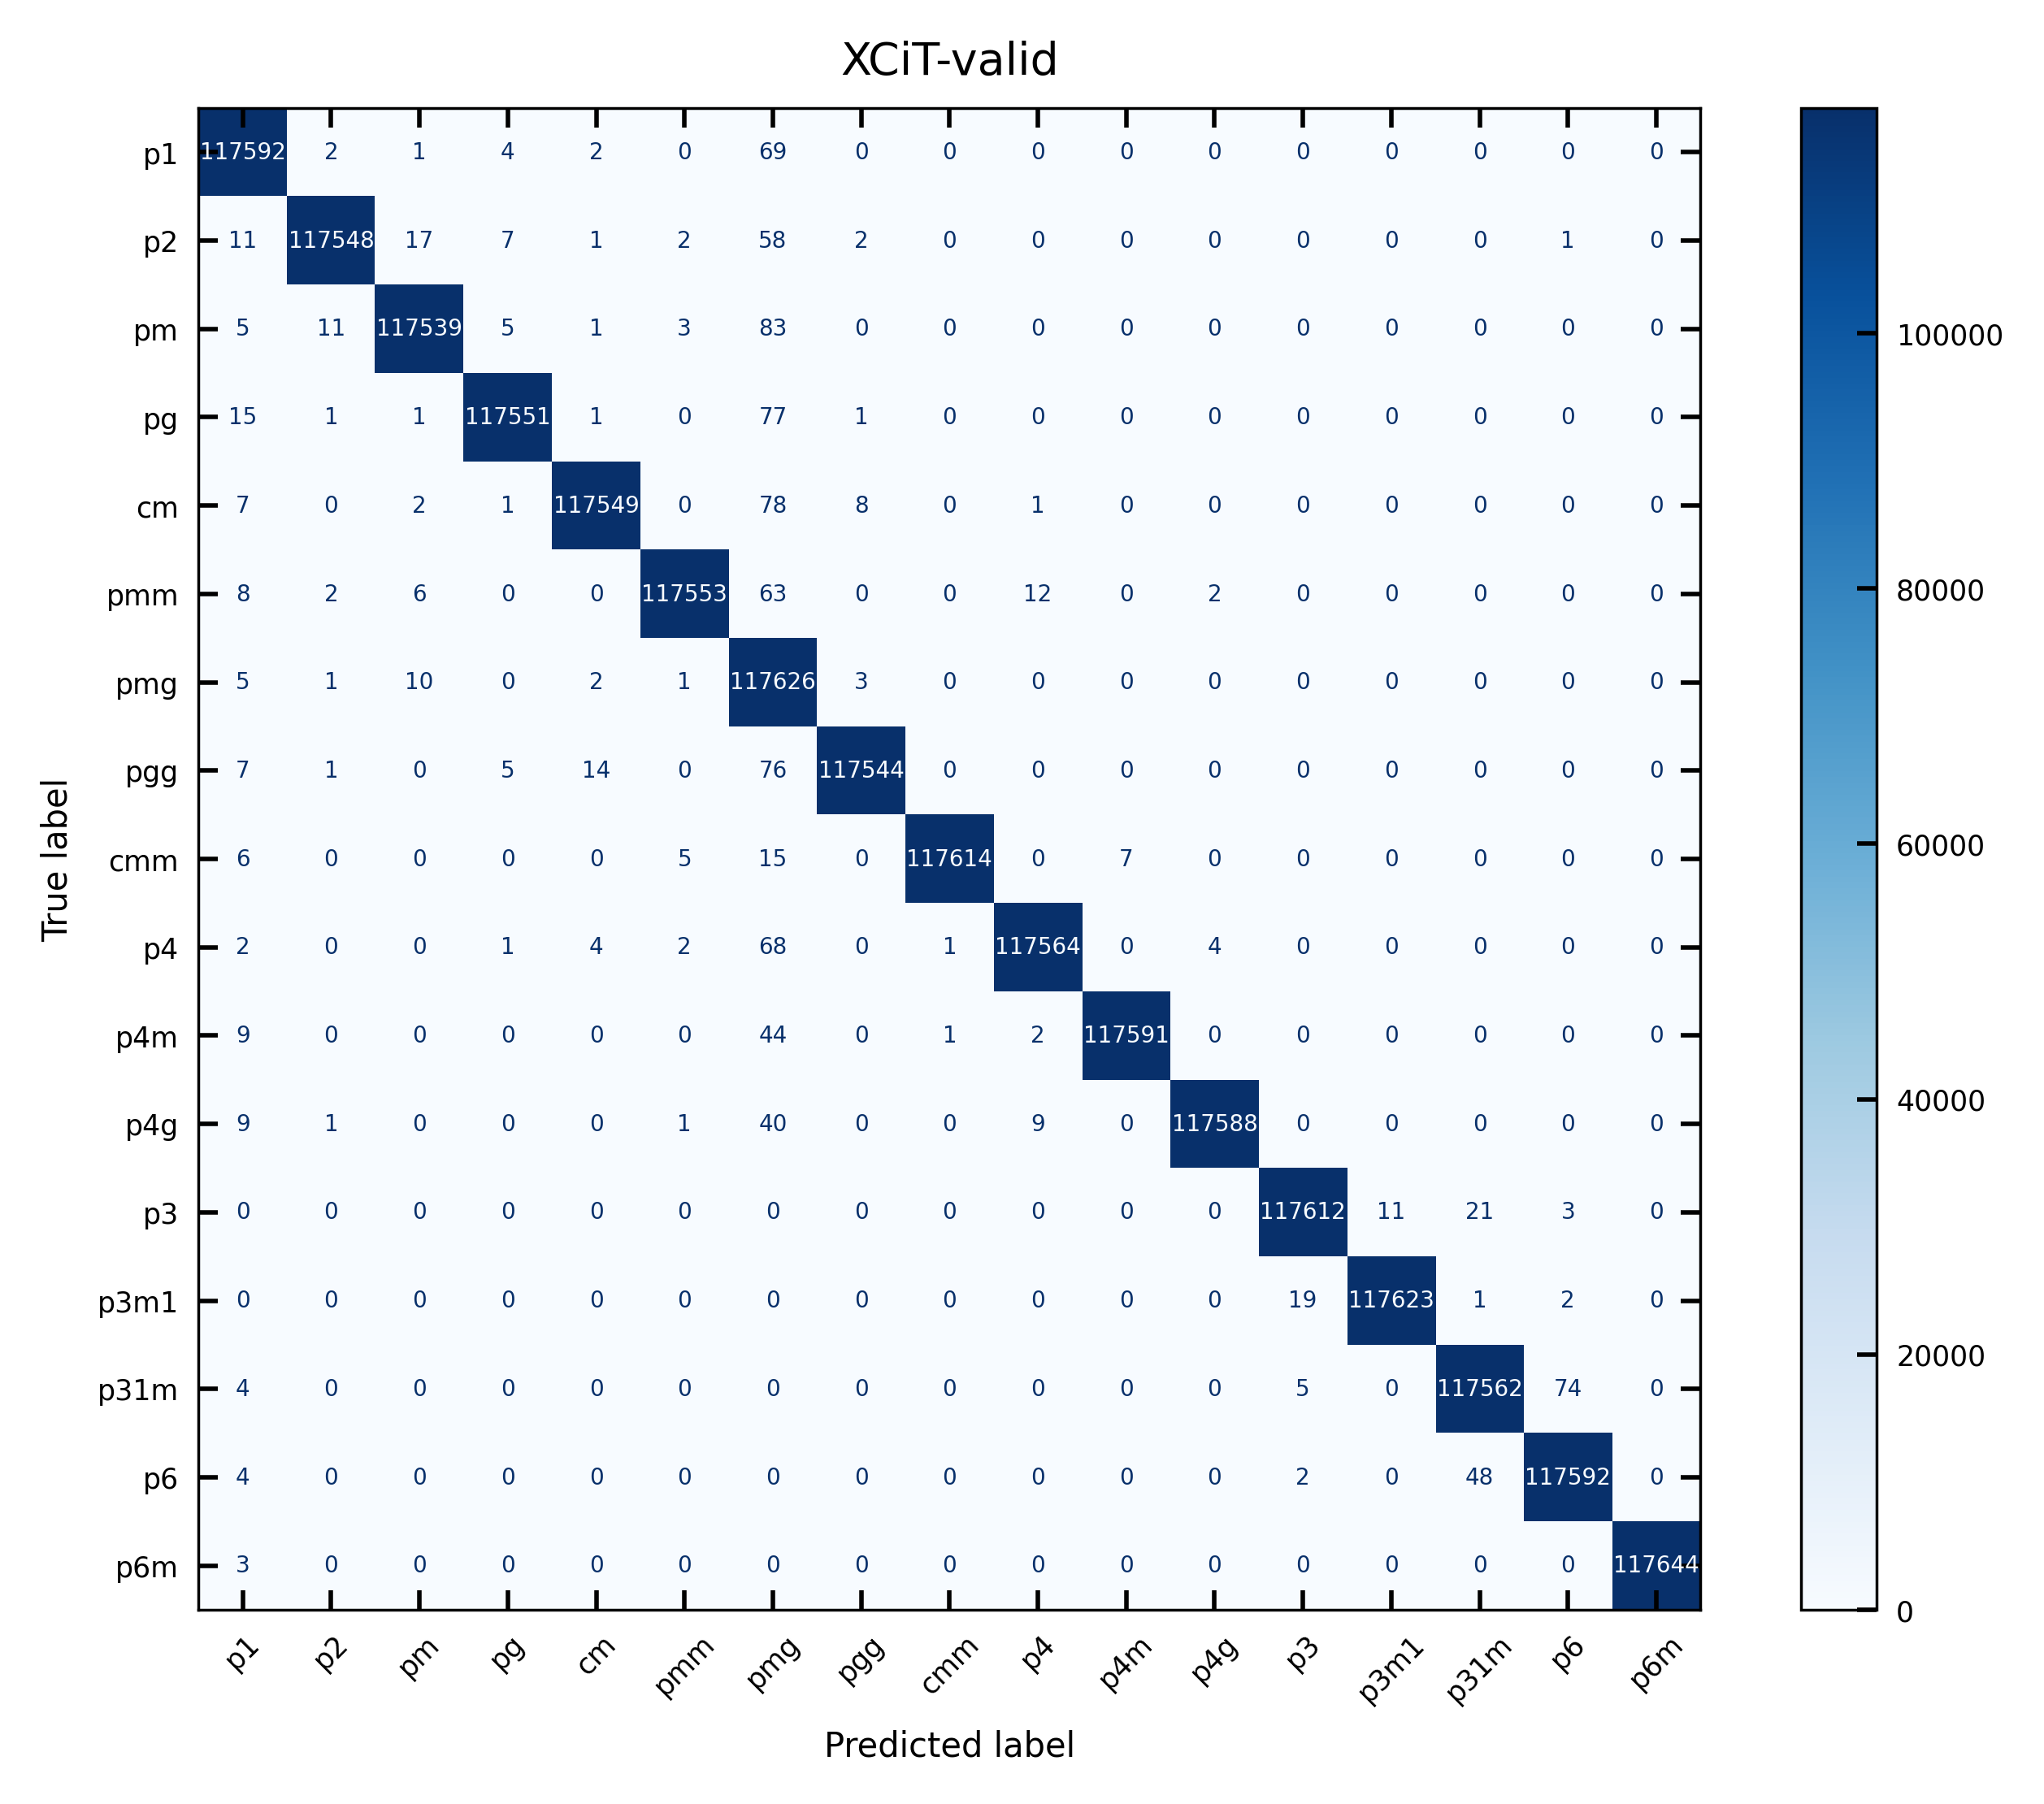

printing set for seaborn


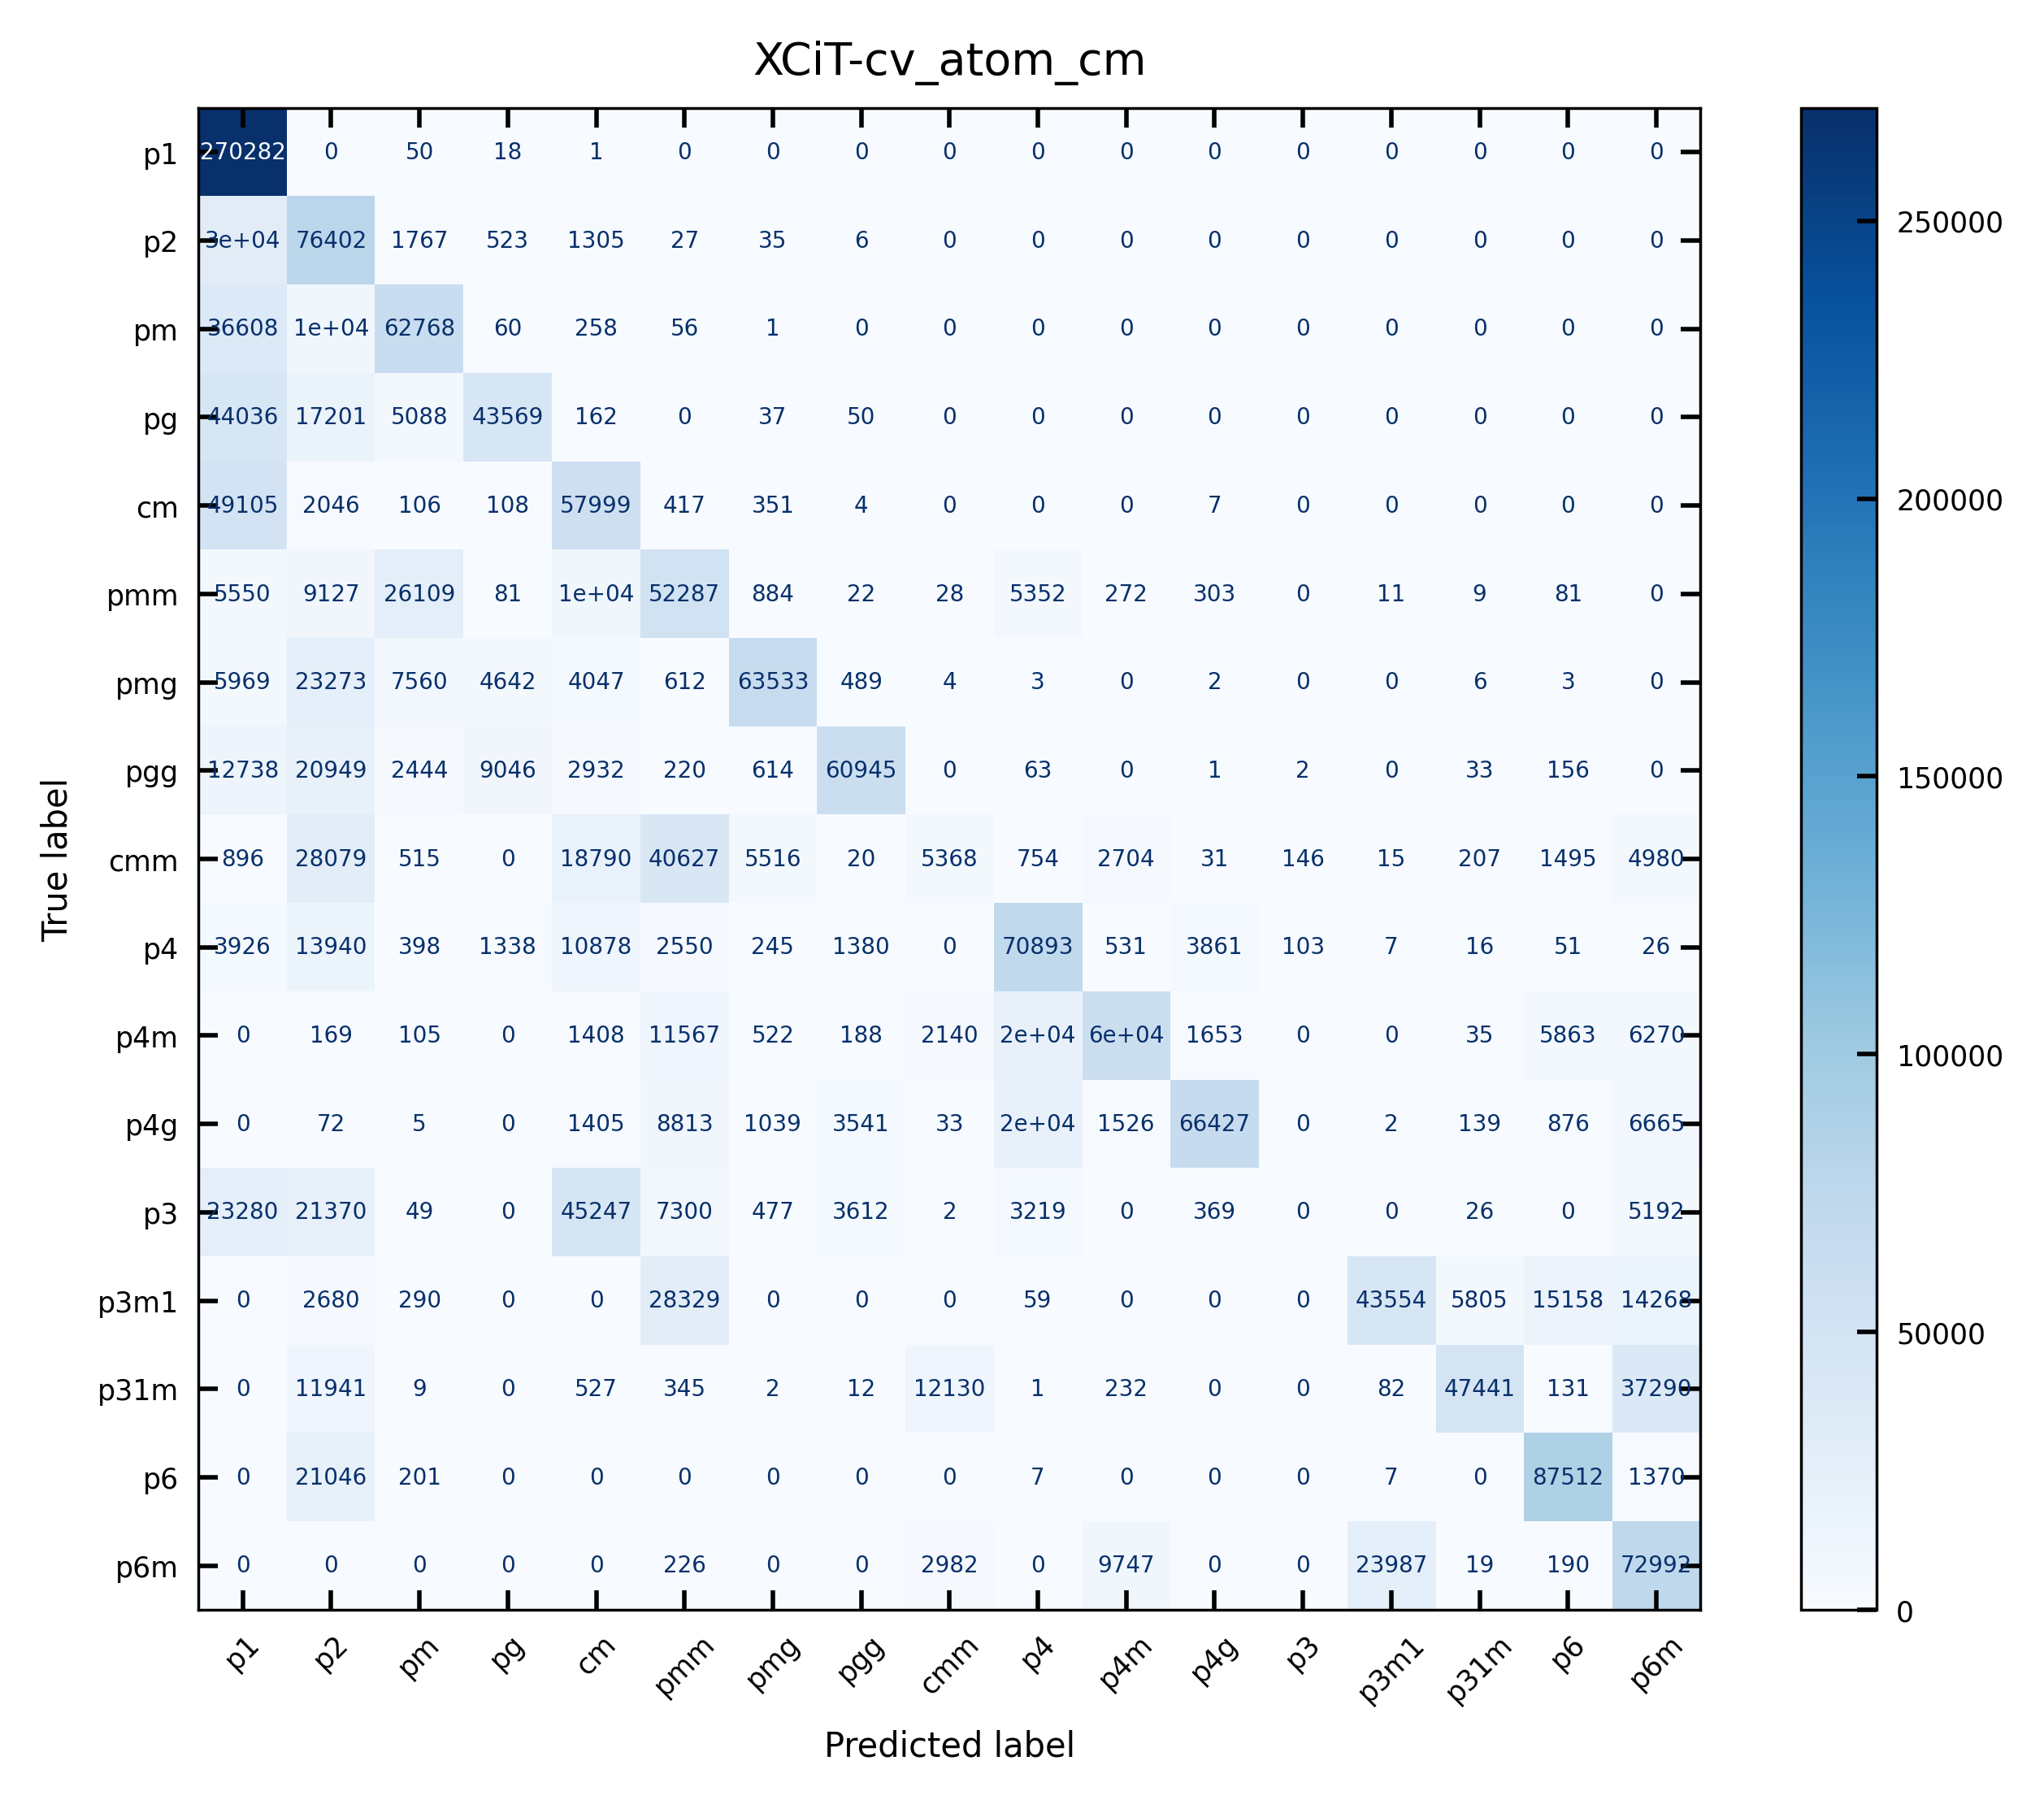

printing set for seaborn


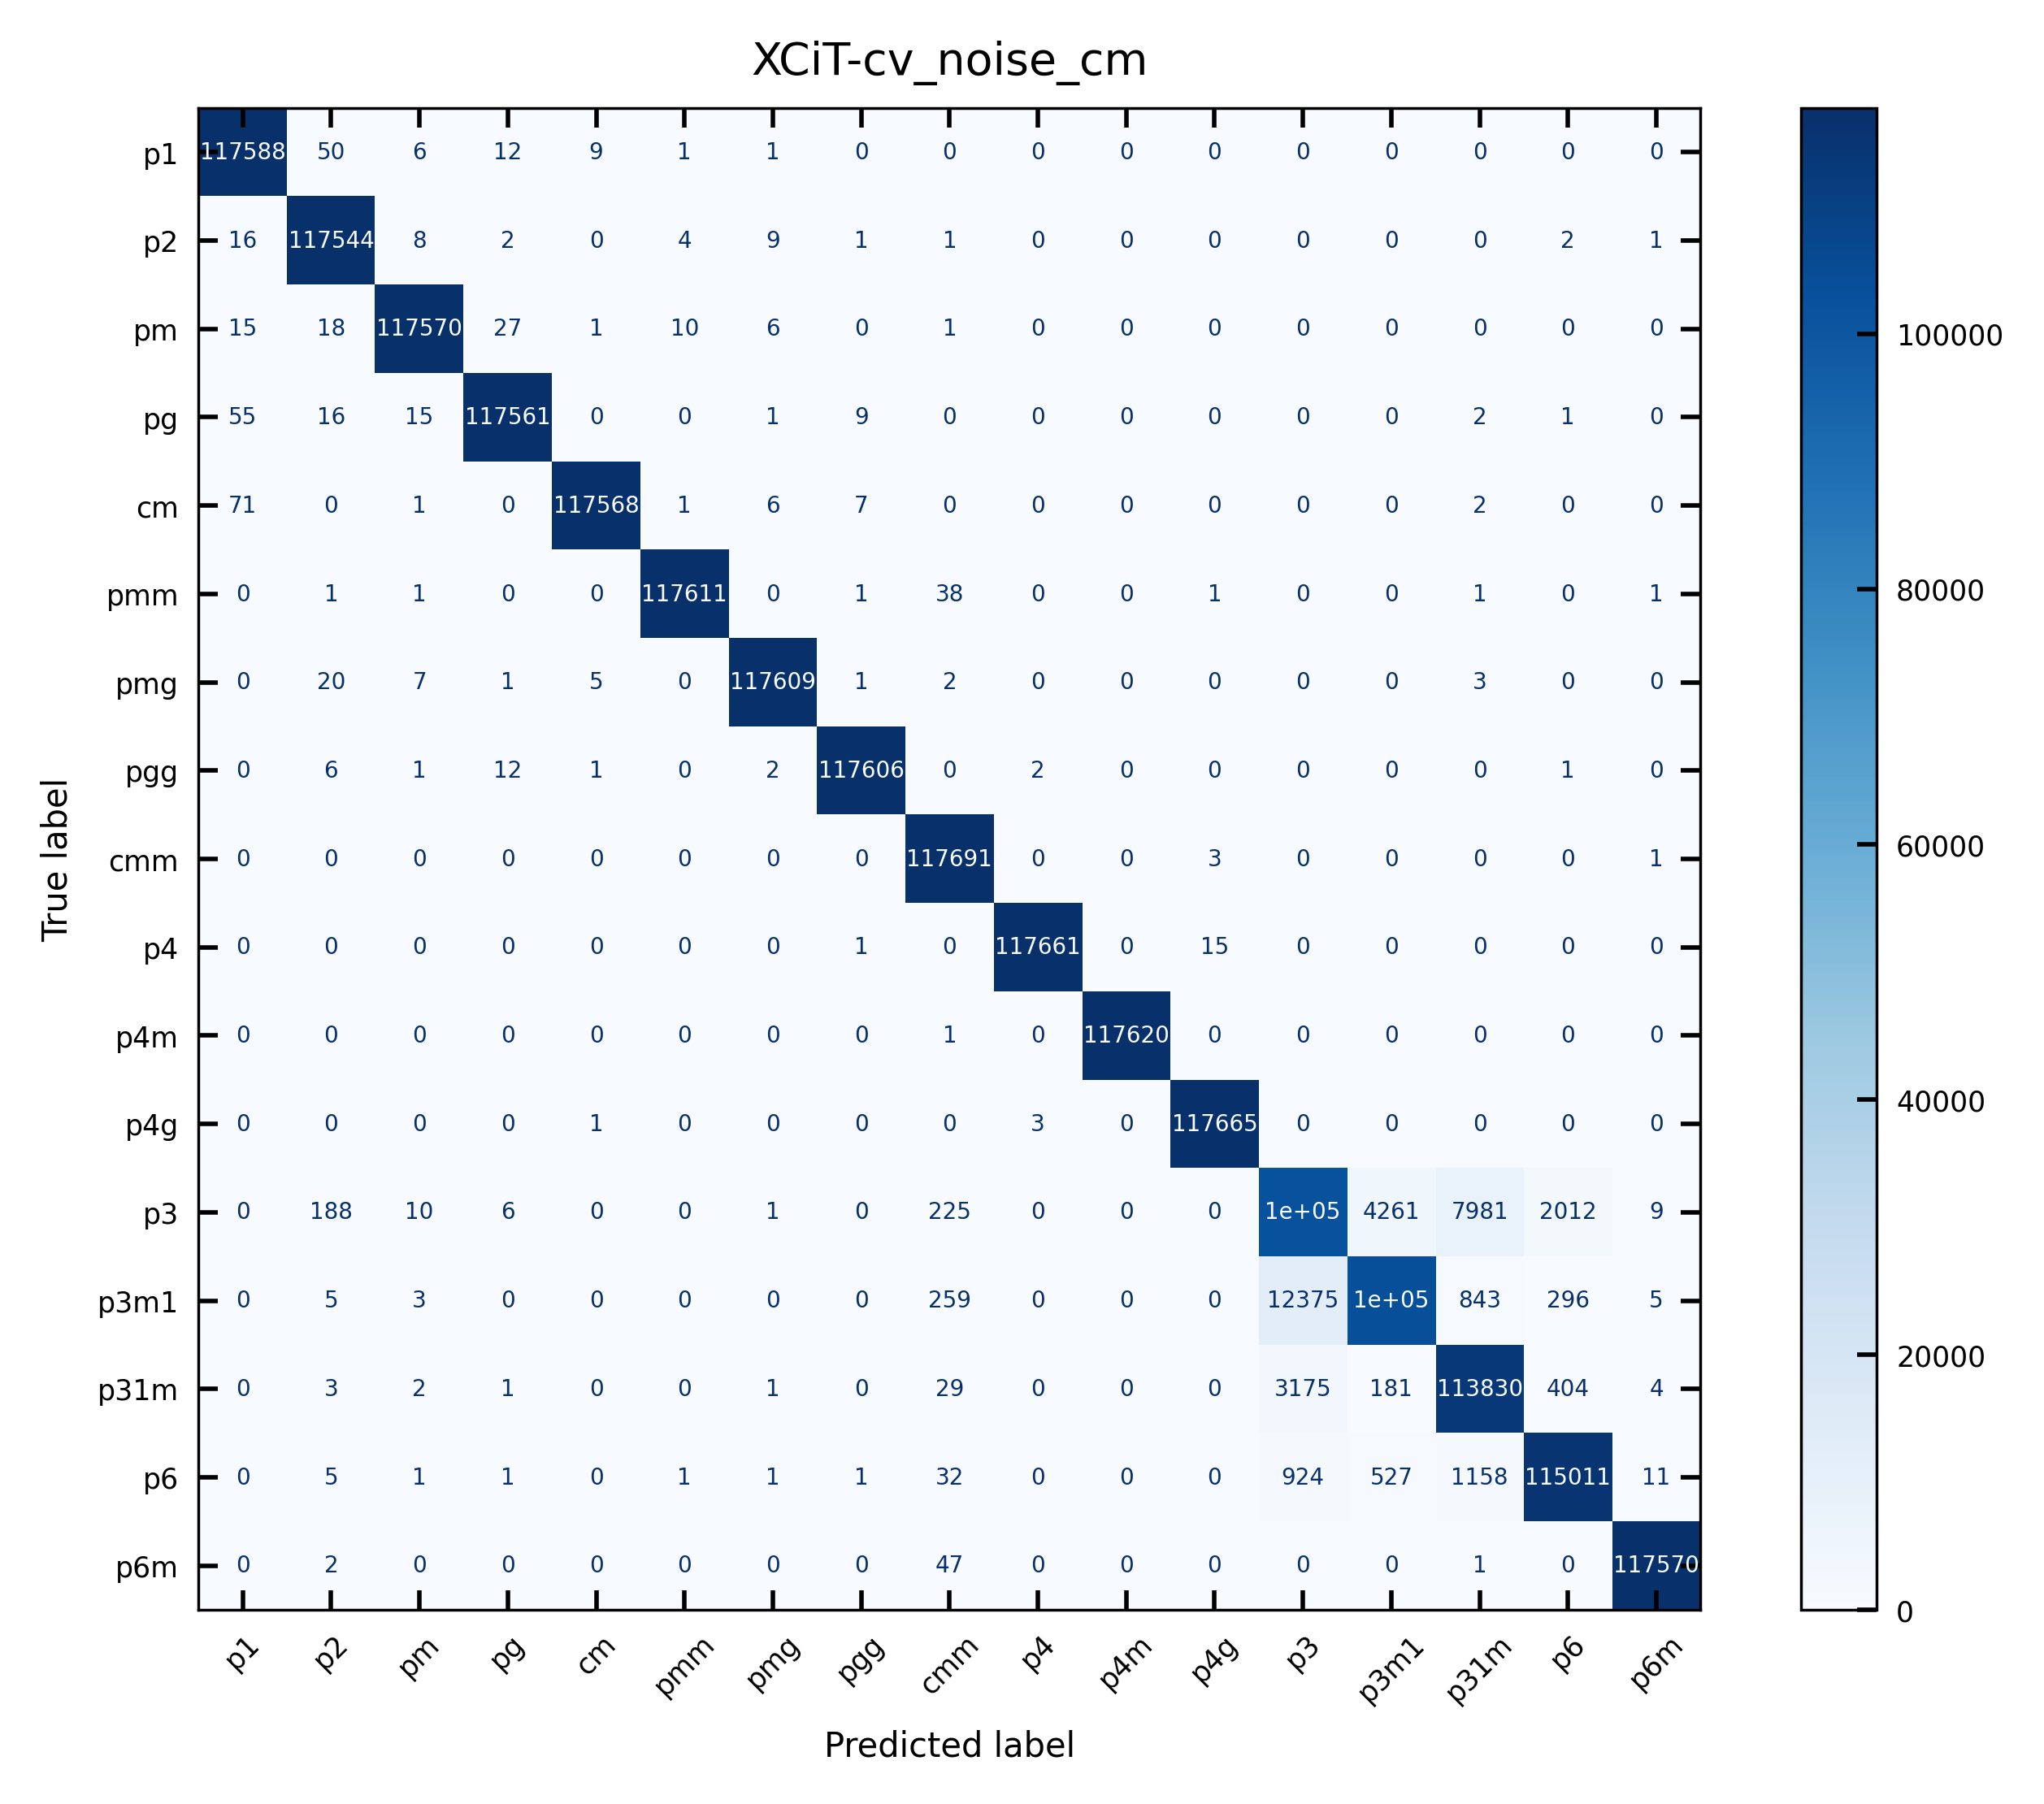

In [29]:
files = glob.glob(f'../../../saved_results/Benchmark/XCiT/*')
keywords = ['train', 'valid', 'cv_atom_cm', 'cv_noise_cm']
show_cm(files, keywords, title_head='XCiT-', file_path=f'../../../figures/Benchmark/XCiT/', cm_style='simple', fig_style='printing', font_size=4)

### visualize confusions in compact layout

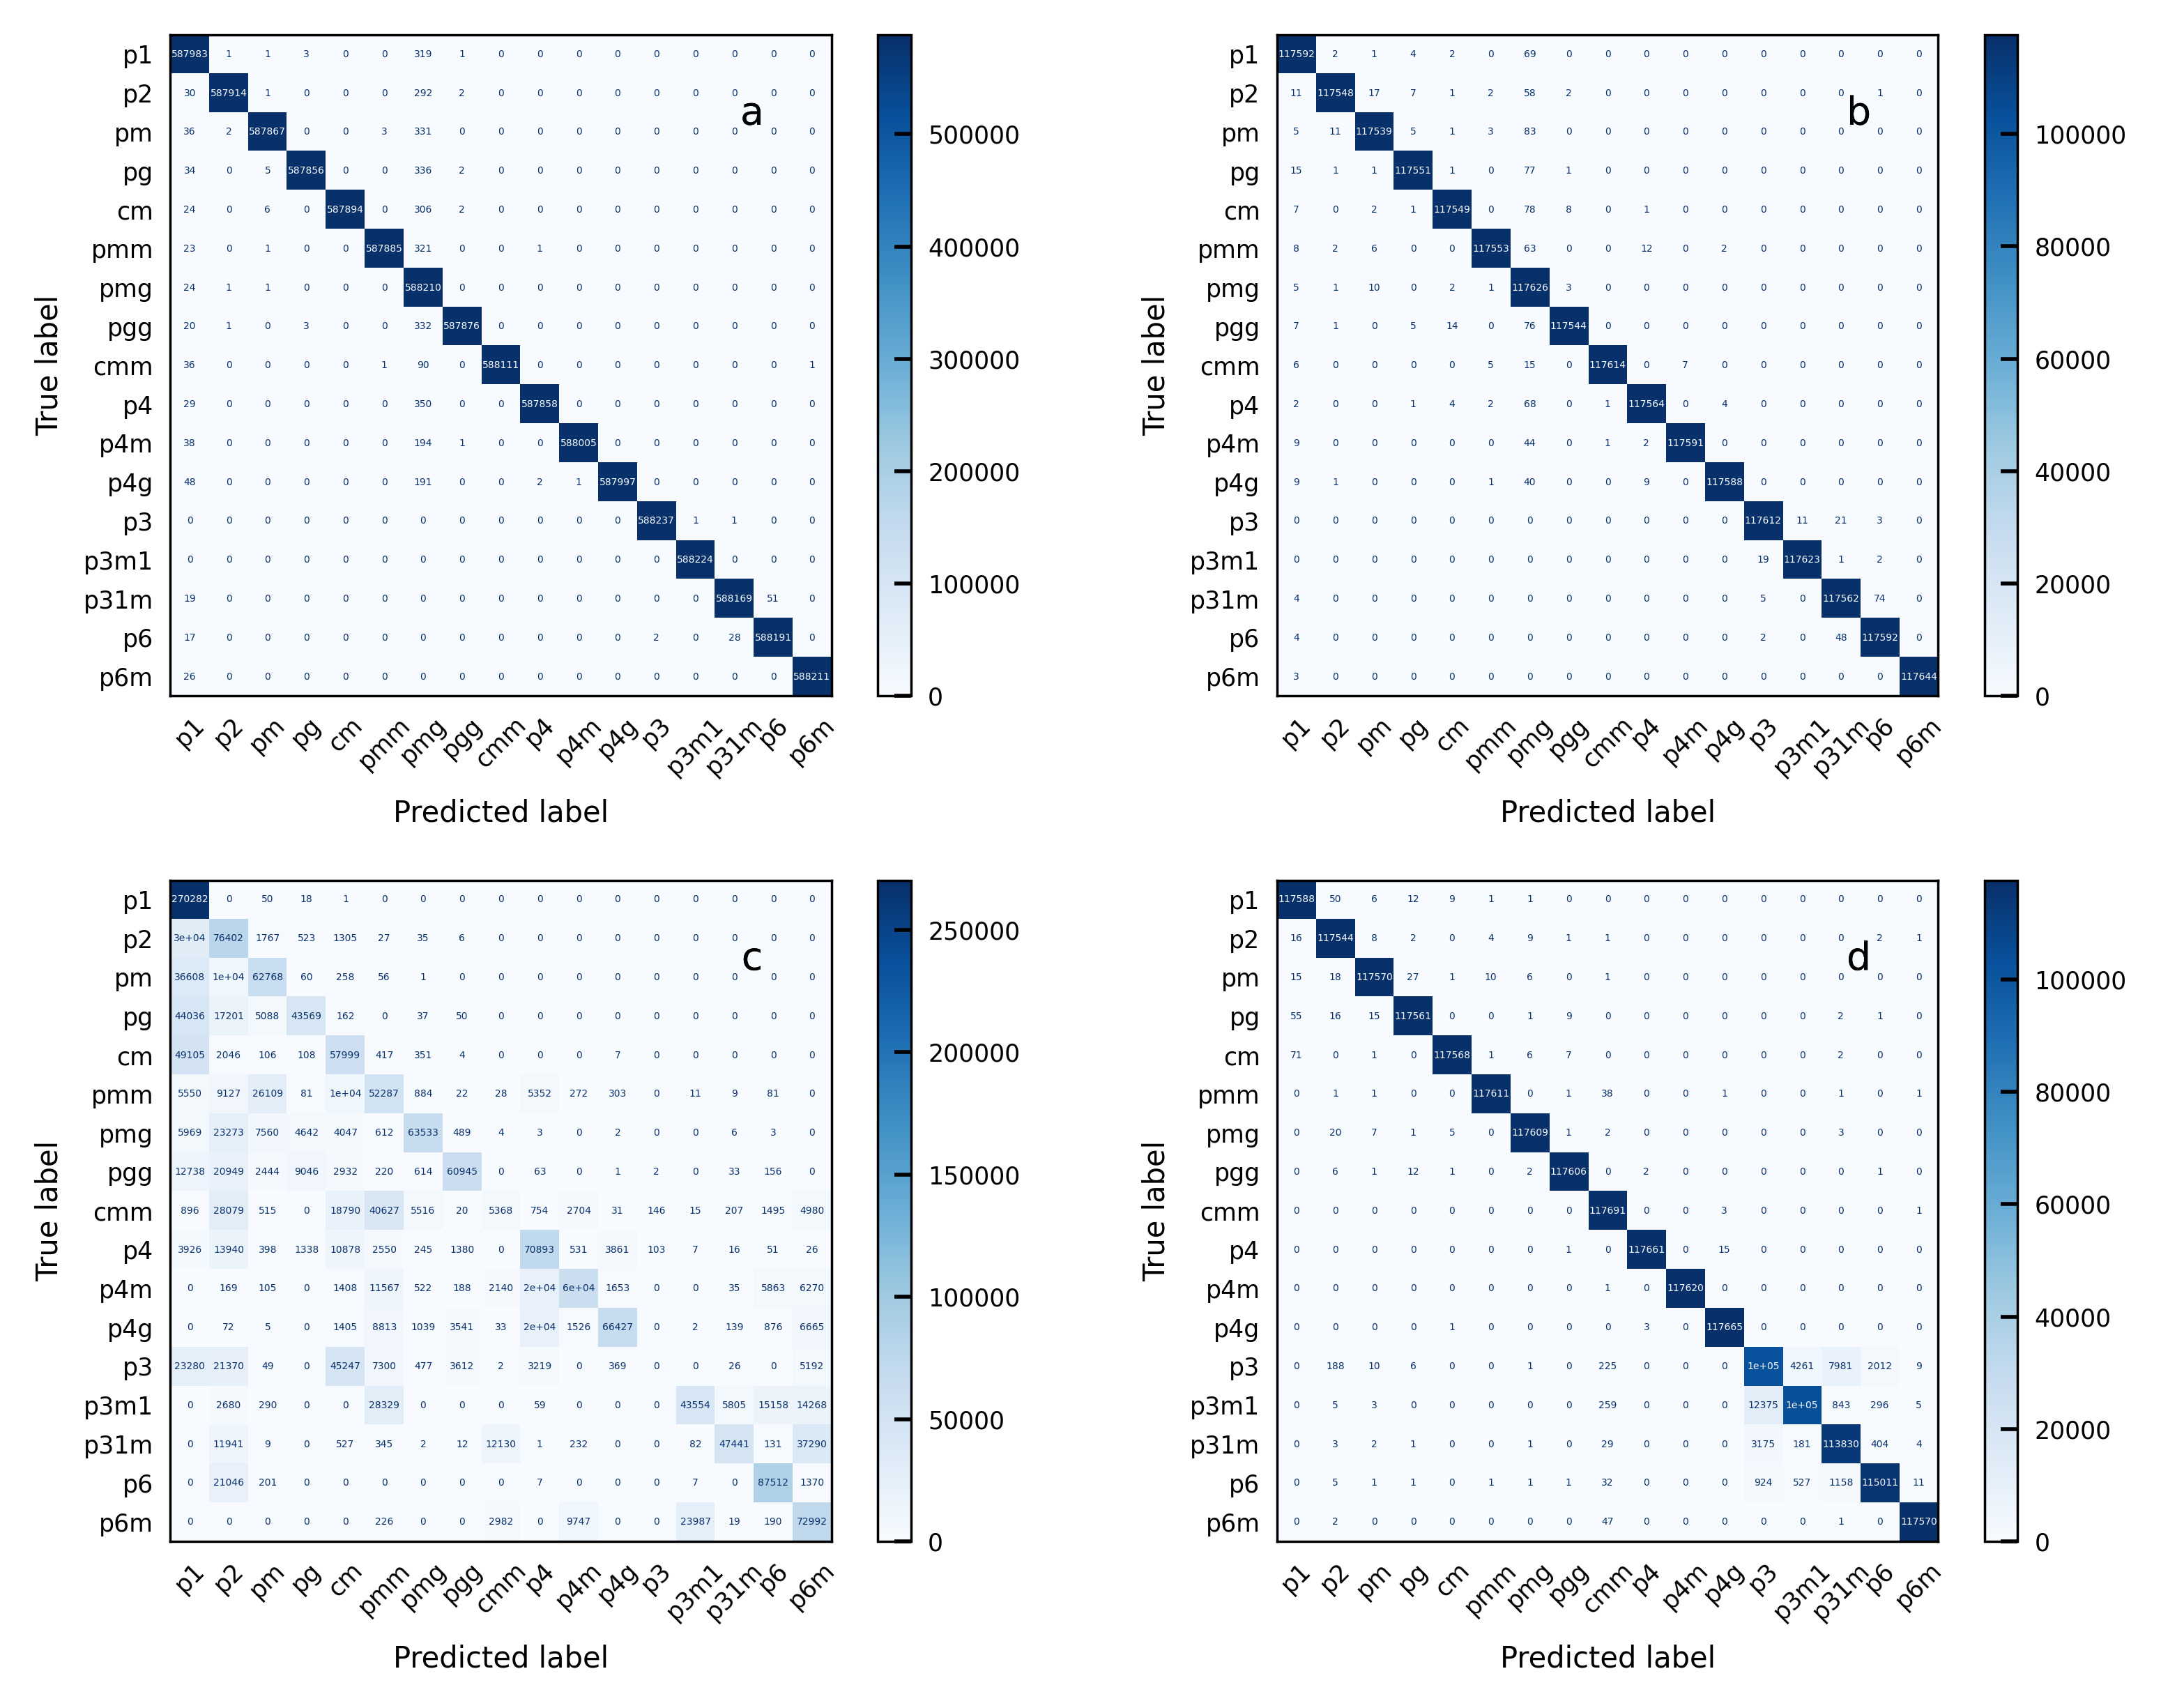

In [27]:
files = glob.glob(f'../../../saved_results/Benchmark/XCiT/*')
keywords = ['train', 'valid', 'cv_atom_cm', 'cv_noise_cm']

show_cm(files, keywords, summary=True, title_head=None, cm_style='simple', fig_style='printing', font_size=2,
        file_path='../../../figures/Benchmark/XCiT/Summary_cm-XCiT')